<a href="https://colab.research.google.com/github/Kirsten-Nancy/1_27DaysOfPython_BeginnerProjects/blob/main/FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import division, absolute_import
import warnings
import torch
from torch import nn
from torch.nn import functional as F

__all__ = [
    'osnet_x1_0', 'osnet_x0_75', 'osnet_x0_5', 'osnet_x0_25', 'osnet_ibn_x1_0'
]

pretrained_urls = {
    'osnet_x1_0':
    'https://drive.google.com/uc?id=1LaG1EJpHrxdAxKnSCJ_i0u-nbxSAeiFY',
    'osnet_x0_75':
    'https://drive.google.com/uc?id=1uwA9fElHOk3ZogwbeY5GkLI6QPTX70Hq',
    'osnet_x0_5':
    'https://drive.google.com/uc?id=16DGLbZukvVYgINws8u8deSaOqjybZ83i',
    'osnet_x0_25':
    'https://drive.google.com/uc?id=1rb8UN5ZzPKRc_xvtHlyDh-cSz88YX9hs',
    'osnet_ibn_x1_0':
    'https://drive.google.com/uc?id=1sr90V6irlYYDd4_4ISU2iruoRG8J__6l'
}


##########
# Basic layers
##########
class ConvLayer(nn.Module):
    """Convolution layer (conv + bn + relu)."""

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        groups=1,
        IN=False
    ):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
            groups=groups
        )
        if IN:
            self.bn = nn.InstanceNorm2d(out_channels, affine=True)
        else:
            self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1(nn.Module):
    """1x1 convolution + bn + relu."""

    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(Conv1x1, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            1,
            stride=stride,
            padding=0,
            bias=False,
            groups=groups
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1Linear(nn.Module):
    """1x1 convolution + bn (w/o non-linearity)."""

    def __init__(self, in_channels, out_channels, stride=1):
        super(Conv1x1Linear, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, 1, stride=stride, padding=0, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Conv3x3(nn.Module):
    """3x3 convolution + bn + relu."""

    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(Conv3x3, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            3,
            stride=stride,
            padding=1,
            bias=False,
            groups=groups
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class LightConv3x3(nn.Module):
    """Lightweight 3x3 convolution.
    1x1 (linear) + dw 3x3 (nonlinear).
    """

    def __init__(self, in_channels, out_channels):
        super(LightConv3x3, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 1, stride=1, padding=0, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            3,
            stride=1,
            padding=1,
            bias=False,
            groups=out_channels
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


##########
# Building blocks for omni-scale feature learning
##########
class ChannelGate(nn.Module):
    """A mini-network that generates channel-wise gates conditioned on input tensor."""

    def __init__(
        self,
        in_channels,
        num_gates=None,
        return_gates=False,
        gate_activation='sigmoid',
        reduction=16,
        layer_norm=False
    ):
        super(ChannelGate, self).__init__()
        if num_gates is None:
            num_gates = in_channels
        self.return_gates = return_gates
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(
            in_channels,
            in_channels // reduction,
            kernel_size=1,
            bias=True,
            padding=0
        )
        self.norm1 = None
        if layer_norm:
            self.norm1 = nn.LayerNorm((in_channels // reduction, 1, 1))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(
            in_channels // reduction,
            num_gates,
            kernel_size=1,
            bias=True,
            padding=0
        )
        if gate_activation == 'sigmoid':
            self.gate_activation = nn.Sigmoid()
        elif gate_activation == 'relu':
            self.gate_activation = nn.ReLU(inplace=True)
        elif gate_activation == 'linear':
            self.gate_activation = None
        else:
            raise RuntimeError(
                "Unknown gate activation: {}".format(gate_activation)
            )

    def forward(self, x):
        input = x
        x = self.global_avgpool(x)
        x = self.fc1(x)
        if self.norm1 is not None:
            x = self.norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.gate_activation is not None:
            x = self.gate_activation(x)
        if self.return_gates:
            return x
        return input * x


class OSBlock(nn.Module):
    """Omni-scale feature learning block."""

    def __init__(
        self,
        in_channels,
        out_channels,
        IN=False,
        bottleneck_reduction=4,
        **kwargs
    ):
        super(OSBlock, self).__init__()
        mid_channels = out_channels // bottleneck_reduction
        self.conv1 = Conv1x1(in_channels, mid_channels)
        self.conv2a = LightConv3x3(mid_channels, mid_channels)
        self.conv2b = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2c = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.conv2d = nn.Sequential(
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
            LightConv3x3(mid_channels, mid_channels),
        )
        self.gate = ChannelGate(mid_channels)
        self.conv3 = Conv1x1Linear(mid_channels, out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = Conv1x1Linear(in_channels, out_channels)
        self.IN = None
        if IN:
            self.IN = nn.InstanceNorm2d(out_channels, affine=True)

    def forward(self, x):
        identity = x
        x1 = self.conv1(x)
        x2a = self.conv2a(x1)
        x2b = self.conv2b(x1)
        x2c = self.conv2c(x1)
        x2d = self.conv2d(x1)
        x2 = self.gate(x2a) + self.gate(x2b) + self.gate(x2c) + self.gate(x2d)
        x3 = self.conv3(x2)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out = x3 + identity
        if self.IN is not None:
            out = self.IN(out)
        return F.relu(out)


##########
# Network architecture
##########
class OSNet(nn.Module):
    """Omni-Scale Network.
    
    Reference:
        - Zhou et al. Omni-Scale Feature Learning for Person Re-Identification. ICCV, 2019.
        - Zhou et al. Learning Generalisable Omni-Scale Representations
          for Person Re-Identification. TPAMI, 2021.
    """

    def __init__(
        self,
        num_classes,
        blocks,
        layers,
        channels,
        feature_dim=512,
        loss='softmax',
        IN=False,
        **kwargs
    ):
        super(OSNet, self).__init__()
        num_blocks = len(blocks)
        assert num_blocks == len(layers)
        assert num_blocks == len(channels) - 1
        self.loss = loss
        self.feature_dim = feature_dim

        # convolutional backbone
        self.conv1 = ConvLayer(3, channels[0], 7, stride=2, padding=3, IN=IN)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = self._make_layer(
            blocks[0],
            layers[0],
            channels[0],
            channels[1],
            reduce_spatial_size=True,
            IN=IN
        )
        self.conv3 = self._make_layer(
            blocks[1],
            layers[1],
            channels[1],
            channels[2],
            reduce_spatial_size=True
        )
        self.conv4 = self._make_layer(
            blocks[2],
            layers[2],
            channels[2],
            channels[3],
            reduce_spatial_size=False
        )
        self.conv5 = Conv1x1(channels[3], channels[3])
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        # fully connected layer
        self.fc = self._construct_fc_layer(
            self.feature_dim, channels[3], dropout_p=None
        )
        # identity classification layer
        self.classifier = nn.Linear(self.feature_dim, num_classes)

        self._init_params()

    def _make_layer(
        self,
        block,
        layer,
        in_channels,
        out_channels,
        reduce_spatial_size,
        IN=False
    ):
        layers = []

        layers.append(block(in_channels, out_channels, IN=IN))
        for i in range(1, layer):
            layers.append(block(out_channels, out_channels, IN=IN))

        if reduce_spatial_size:
            layers.append(
                nn.Sequential(
                    Conv1x1(out_channels, out_channels),
                    nn.AvgPool2d(2, stride=2)
                )
            )

        return nn.Sequential(*layers)

    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):
        if fc_dims is None or fc_dims < 0:
            self.feature_dim = input_dim
            return None

        if isinstance(fc_dims, int):
            fc_dims = [fc_dims]

        layers = []
        for dim in fc_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU(inplace=True))
            if dropout_p is not None:
                layers.append(nn.Dropout(p=dropout_p))
            input_dim = dim

        self.feature_dim = fc_dims[-1]

        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

    def forward(self, x, return_featuremaps=False):
        x = self.featuremaps(x)
        if return_featuremaps:
            return x
        v = self.global_avgpool(x)
        v = v.view(v.size(0), -1)
        if self.fc is not None:
            v = self.fc(v)
        if not self.training:
            return v
        y = self.classifier(v)
        if self.loss == 'softmax':
            return y
        elif self.loss == 'triplet':
            return y, v
        else:
            raise KeyError("Unsupported loss: {}".format(self.loss))


def init_pretrained_weights(model, key=''):
    """Initializes model with pretrained weights.
    
    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    import os
    import errno
    import gdown
    from collections import OrderedDict

    def _get_torch_home():
        ENV_TORCH_HOME = 'TORCH_HOME'
        ENV_XDG_CACHE_HOME = 'XDG_CACHE_HOME'
        DEFAULT_CACHE_DIR = '~/.cache'
        torch_home = os.path.expanduser(
            os.getenv(
                ENV_TORCH_HOME,
                os.path.join(
                    os.getenv(ENV_XDG_CACHE_HOME, DEFAULT_CACHE_DIR), 'torch'
                )
            )
        )
        return torch_home

    torch_home = _get_torch_home()
    model_dir = os.path.join(torch_home, 'checkpoints')
    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise
    filename = key + '_imagenet.pth'
    cached_file = os.path.join(model_dir, filename)

    if not os.path.exists(cached_file):
        gdown.download(pretrained_urls[key], cached_file, quiet=False)

    state_dict = torch.load(cached_file)
    model_dict = model.state_dict()
    new_state_dict = OrderedDict()
    matched_layers, discarded_layers = [], []

    for k, v in state_dict.items():
        if k.startswith('module.'):
            k = k[7:] # discard module.

        if k in model_dict and model_dict[k].size() == v.size():
            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)

    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)

    if len(matched_layers) == 0:
        warnings.warn(
            'The pretrained weights from "{}" cannot be loaded, '
            'please check the key names manually '
            '(** ignored and continue **)'.format(cached_file)
        )
    else:
        print(
            'Successfully loaded imagenet pretrained weights from "{}"'.
            format(cached_file)
        )
        if len(discarded_layers) > 0:
            print(
                '** The following layers are discarded '
                'due to unmatched keys or layer size: {}'.
                format(discarded_layers)
            )


##########
# Instantiation
##########
def osnet_x1_0(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # standard size (width x1.0)
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[64, 256, 384, 512],
        loss=loss,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, key='osnet_x1_0')
    return model


def osnet_x0_75(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # medium size (width x0.75)
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[48, 192, 288, 384],
        loss=loss,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_75')
    return model


def osnet_x0_5(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # tiny size (width x0.5)
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[32, 128, 192, 256],
        loss=loss,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_5')
    return model


def osnet_x0_25(num_classes=1000, pretrained=True, loss='softmax', **kwargs):
    # very tiny size (width x0.25)
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[16, 64, 96, 128],
        loss=loss,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, key='osnet_x0_25')
    return model


def osnet_ibn_x1_0(
    num_classes=1000, pretrained=True, loss='softmax', **kwargs
):
    # standard size (width x1.0) + IBN layer
    # Ref: Pan et al. Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net. ECCV, 2018.
    model = OSNet(
        num_classes,
        blocks=[OSBlock, OSBlock, OSBlock],
        layers=[2, 2, 2],
        channels=[64, 256, 384, 512],
        loss=loss,
        IN=True,
        **kwargs
    )
    if pretrained:
        init_pretrained_weights(model, key='osnet_ibn_x1_0')
    return model

In [2]:
model = osnet_ibn_x1_0()

Downloading...
From: https://drive.google.com/uc?id=1sr90V6irlYYDd4_4ISU2iruoRG8J__6l
To: /root/.cache/torch/checkpoints/osnet_ibn_x1_0_imagenet.pth
100%|██████████| 10.9M/10.9M [00:00<00:00, 114MB/s]


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ibn_x1_0_imagenet.pth"


In [3]:
import cv2
import numpy as np
# img=cv2.imread("play.jpg")
# img=cv2.resize(img,(256, 256))
# img=np.asarray([img]) / 255.0
# img = torch.tensor(img).permute(0, 3, 1, 2).float()

In [4]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

     |████████████████████████████████| 274 kB 27.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=7d57fbd57516e3a55f7932a3217b4372f607322d84b4265629f3f42fb9ef5f0c
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 453 kB/s 
     |████████████████████████████████| 74 kB 3.3 MB/s 
     |████████████████████████████████| 145 kB 50.9 MB/s 
     |████████████████████████████████| 130 kB 27.4 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 749 kB 47.2 MB/s 
     |████████████████████████████████| 843 kB 72.9 MB/s 
     |

In [5]:
from tqdm import tqdm
from pprint import pprint

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:

class PeopleKeypointDetectionHook:
    def __init__(self, device, model_config_file):
        
        # detectron2 config
        self.cfg = get_cfg()
        self.cfg.MODEL.DEVICE=device
        self.cfg.merge_from_file(model_zoo.get_config_file(model_config_file))
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_file)
        
        self.predictor = DefaultPredictor(self.cfg)
        
    def predict(self, img):
        outputs = self.predictor(img)
        
        return outputs
    
    def visualize_prediction(self, img, outputs, scale, figsize):
        v = Visualizer(img[:,:,::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]), scale=scale)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=figsize)
        plt.imshow(cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB))

In [7]:

def render_video(video_path, model):
    video = cv2.VideoCapture(video_path)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_count = 0
    cropped_bbox_image_list = []
    while True:
        is_frame, frame = video.read()

        if not is_frame:
            break
            
        model_outputs = model.predict(frame)
        
        # Retrieving bbox
        bboxes = model_outputs["instances"][model_outputs["instances"].pred_classes == 0].pred_boxes
        
        for bbox in bboxes:
            x1, y1, x2, y2 = [int(x.cpu().item()) for x in list(bbox.squeeze())]
            cropped_bbox = frame[y1:y2, x1:x2]
            cropped_bbox_image_list.append(cropped_bbox)
        
        frame_count += 1
        
        if frame_count == 5:
            break
    
    # Crops the images
    return cropped_bbox_image_list

In [8]:
keypoint_detection = PeopleKeypointDetectionHook(device="cpu", 
                                                 model_config_file="COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml",
                                                )

model_final_a6e10b.pkl: 237MB [00:15, 15.2MB/s]                           


In [9]:
cropped_bbox_image_list = render_video(video_path="./sample_video.mp4", model=keypoint_detection)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pyt

In [10]:
cropped_bbox_image_list

[array([[[ 68,  71, 103],
         [ 66,  69, 101],
         [ 65,  68, 100],
         ...,
         [118, 121, 173],
         [117, 120, 172],
         [ 91,  91, 146]],
 
        [[ 59,  62,  94],
         [ 76,  79, 111],
         [ 90,  93, 125],
         ...,
         [ 97, 100, 152],
         [ 96,  99, 151],
         [ 90,  90, 145]],
 
        [[ 68,  71, 103],
         [ 91,  94, 126],
         [108, 111, 143],
         ...,
         [ 84,  86, 136],
         [ 83,  85, 135],
         [ 83,  83, 138]],
 
        ...,
 
        [[107, 113, 108],
         [107, 113, 108],
         [107, 113, 108],
         ...,
         [182, 201, 192],
         [184, 203, 194],
         [186, 205, 196]],
 
        [[ 75,  81,  76],
         [ 75,  81,  76],
         [ 74,  80,  75],
         ...,
         [152, 171, 162],
         [153, 172, 163],
         [156, 175, 166]],
 
        [[ 50,  80,  71],
         [ 51,  81,  72],
         [ 51,  81,  72],
         ...,
         [144, 151, 144],
  

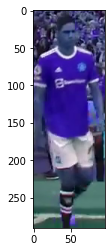

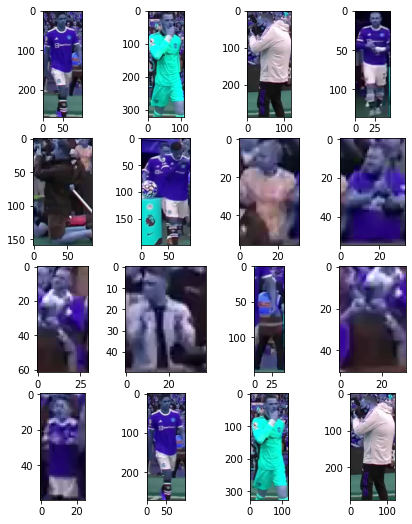

In [11]:
from matplotlib import pyplot as plt
plt.imshow(cropped_bbox_image_list[44])
plt.show()

plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
 plt.subplots_adjust(bottom)
 plt.subplot(4,4,i+1)
#  plt.title(‘Number:{}’.format(reference_labels[i]),fontsize = 17)
 plt.imshow(cropped_bbox_image_list[i])


In [12]:
features = []
model.eval()
with torch.no_grad():
  for img in cropped_bbox_image_list:
    img=cv2.resize(img,(256, 256))
    img=np.asarray([img]) / 255.0
    img = torch.tensor(img).permute(0, 3, 1, 2).float()
    features.append(model(img).detach().cpu().numpy())

In [13]:
features

[array([[0.        , 2.7449849 , 0.5768121 , 0.        , 0.        ,
         0.        , 0.65016997, 0.5136371 , 0.        , 0.6631691 ,
         2.3654602 , 1.2876172 , 2.3998795 , 0.9561708 , 1.3048177 ,
         2.8450158 , 0.        , 2.353697  , 1.1212358 , 1.3539212 ,
         0.7484983 , 0.        , 2.6593704 , 0.        , 2.119533  ,
         0.05705447, 0.42121282, 0.        , 0.6629467 , 0.24556422,
         0.        , 0.737566  , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.96934247, 0.        ,
         0.5860091 , 0.        , 0.21194638, 1.5006089 , 0.        ,
         1.2468177 , 0.        , 0.        , 3.2090545 , 0.702555  ,
         2.7134633 , 0.        , 1.3341757 , 1.7882192 , 1.8312169 ,
         1.0022693 , 0.25582308, 0.        , 0.        , 0.7542249 ,
         2.505371  , 2.485659  , 0.65021664, 0.5685875 , 0.3068123 ,
         0.        , 1.181534  , 0.74936026, 0.        , 0.6389866 ,
         0.1155414 , 0.        , 0

In [14]:
from sklearn.cluster import KMeans

In [15]:
feature_arr = np.array(features).squeeze()

In [16]:
feature_arr.shape

(57, 512)

In [17]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(feature_arr)

In [18]:
predictions = kmeans.predict(feature_arr)
predictions

array([0, 2, 2, 4, 3, 5, 1, 1, 1, 1, 4, 1, 1, 0, 2, 2, 4, 3, 1, 5, 1, 1,
       1, 1, 0, 2, 2, 4, 3, 5, 1, 1, 1, 1, 0, 2, 2, 4, 3, 5, 1, 1, 1, 1,
       0, 2, 2, 4, 5, 3, 1, 4, 1, 1, 1, 3, 1], dtype=int32)

ReID
1. Change to DBScan
2. Clustering Hook
3. Re-id(query version) Hook
4. Bbox to frame hook(common)


In [20]:
centroids = centers.reshape(6,16,32)
centroids = centroids * 255
centroids.shape

(6, 16, 32)

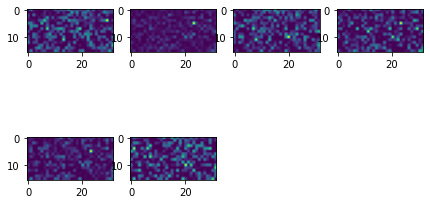

In [21]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(6):
 plt.subplots_adjust(bottom)
 plt.subplot(4,4,i+1)
#  plt.title(‘Number:{}’.format(reference_labels[i]),fontsize = 17)
 plt.imshow(centroids[i])

# for ci in centers: 
#   # print(ci)
#   # break
#   plt.imshow(ci)
#   plt.show()

In [50]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.1, min_samples=5).fit_predict(feature_arr)


In [51]:
db


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])